In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.applications import ResNet50

2024-10-10 09:45:20.885968: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 09:45:21.130755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-10 09:45:22.225845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h2>Builds a ResNet model. Extracts the important features out of the image.</h2>

In [2]:
def build_image_model(input_shape):
    # Load pre-trained ResNet50, excluding the top classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers to retain learned features

    # Add a global average pooling layer and a dense layer
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)  # Intermediate dense layer for features

    return Model(inputs=base_model.input, outputs=x)


<h2></h2>

In [3]:
def build_metadata_model():
    # Image model branch
    input_img = Input(shape=(224, 224, 3), name='image_input')
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model
    x = base_model(input_img)
    x = Flatten()(x)

    # Metadata model branch
    input_meta = Input(shape=(3,), name='metadata_input')
    meta = Dense(32, activation='relu')(input_meta)

    # Concatenate image and metadata branches
    combined = Concatenate()([x, meta])
    combined = Dense(128, activation='relu')(combined)
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, name='output')(combined)  # Regression output for stable height

    # Compile the model
    model = Model(inputs=[input_img, input_meta], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Display the model architecture
    model.summary()
    return model


In [4]:
def build_combined_model(image_input_shape):
    # Build the image and metadata models
    image_model = build_image_model(image_input_shape)
    #metadata_model = build_metadata_model()

    # Concatenate the outputs of the two models
    #combined_input = layers.concatenate([image_model.output, metadata_model.output])

    # Add some fully connected layers for final prediction
    x = layers.Dense(128, activation='relu')(image_model.output)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(6, activation='softmax', name='height_output')(x)  # Classification output


    # Define the final model with both image and metadata inputs
    #combined_model = Model(inputs=[image_model.input, metadata_model.input], outputs=output)
    combined_model = Model(inputs=image_model.input, outputs=output)

    # Compile the model
    combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return combined_model



In [5]:
import os
import cv2

In [6]:
def load_images_from_folder(folder_path, ids, image_size=(224, 224)):
    images = []
    for id in ids:
        filename = str(int(id)) + '.jpg'
        print(filename)
        # Load the image using OpenCV
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        # Resize the image to the target size (224, 224)
        img = cv2.resize(img, image_size)

        # Convert BGR (OpenCV default) to RGB if needed (TensorFlow models use RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalize pixel values to the range [0, 1]
        img_array = img / 255.0

        images.append(img_array)

    # Convert the list of images to a NumPy array with shape (n, 224, 224, 3)
    return np.array(images)

In [7]:
# Fill in the path for the image files
folder_path = '../COMP90086_2024_Project_train/train'
# Load the labels
train = np.genfromtxt('../COMP90086_2024_Project_train/train.csv', delimiter=',', skip_header=1)
ids = train[:, 0]
labels = np.array(train[:, 6], dtype=int)
adjusted_labels = labels - 1

# Load the images from the folder
image_data = load_images_from_folder(folder_path, ids)

# Verify the shape of the NumPy array
print("Image data shape:", image_data.shape)


54.jpg
173.jpg
245.jpg
465.jpg
611.jpg
758.jpg
1012.jpg
1075.jpg
1084.jpg
1121.jpg
1247.jpg
1400.jpg
1686.jpg
1706.jpg
1732.jpg
1928.jpg
2126.jpg
2322.jpg
2382.jpg
2670.jpg
2916.jpg
3178.jpg
3242.jpg
3247.jpg
3414.jpg
3418.jpg
3531.jpg
3649.jpg
3713.jpg
3774.jpg
4203.jpg
4384.jpg
4418.jpg
4487.jpg
4566.jpg
4723.jpg
4955.jpg
5137.jpg
5147.jpg
5238.jpg
5255.jpg
5434.jpg
5689.jpg
5993.jpg
6144.jpg
6255.jpg
6336.jpg
6507.jpg
6584.jpg
6589.jpg
6595.jpg
6604.jpg
6661.jpg
6882.jpg
6972.jpg
7052.jpg
7103.jpg
7168.jpg
7277.jpg
7294.jpg
7379.jpg
7498.jpg
7581.jpg
7613.jpg
7757.jpg
7884.jpg
8609.jpg
8673.jpg
8704.jpg
8749.jpg
8931.jpg
9034.jpg
9087.jpg
9218.jpg
9249.jpg
9511.jpg
9748.jpg
9853.jpg
9889.jpg
10041.jpg
10227.jpg
10259.jpg
10352.jpg
10400.jpg
10407.jpg
10421.jpg
11030.jpg
11223.jpg
11413.jpg
11537.jpg
11974.jpg
12401.jpg
12536.jpg
12697.jpg
12746.jpg
12831.jpg
12892.jpg
13009.jpg
13443.jpg
13523.jpg
13602.jpg
13611.jpg
13655.jpg
13728.jpg
13782.jpg
14102.jpg
14231.jpg
14566.jpg
14661.

In [8]:
# # Dummy data (replace with actual data)
# image_data = np.random.rand(100, 224, 224, 3)  # 100 images, 224x224 resolution, 3 channels (RGB)
# heights = np.random.rand(100, 1)  # Total heights (e.g., 0 to 1 range)
# instability_types = np.random.randint(0, 2, size=(100, 1))  # 0 or 1 for center of mass vs. non-planar
# camera_angles = np.random.randint(0, 2, size=(100, 1))  # 0 for high angle, 1 for low angle

# # Normalize image data and metadata if necessary
# image_data = image_data / 255.0


In [9]:
# Define input shapes
image_input_shape = (224, 224, 3)  # Example image size (224x224)

# Build the combined model
model = build_combined_model(image_input_shape)

# Train the model
history = model.fit(
    image_data,  # Input data
    adjusted_labels,  # Target output (stable height)
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 177s 904ms/step - accuracy: 0.2369 - loss: 1.7081 - val_accuracy: 0.2337 - val_loss: 1.6986
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 173s 899ms/step - accuracy: 0.2590 - loss: 1.6868 - val_accuracy: 0.2415 - val_loss: 1.6927
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 172s 899ms/step - accuracy: 0.2492 - loss: 1.6873 - val_accuracy: 0.2422 - val_loss: 1.6885
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 175s 915ms/step - accuracy: 0.2566 - loss: 1.6804 - val_accuracy: 0.2337 - val_loss: 1.7088
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 175s 912ms/step - accuracy: 0.2419 - loss: 1.6833 - val_accuracy: 0.2337 - val_loss: 1.6907
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 179s 931ms/step - accuracy: 0.2599 - loss: 1.6695 - val_accuracy: 0.2337 - val_loss: 1.6960
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 179s 934ms/step - accuracy: 0.2569 - loss: 1.6861 - val_accuracy: 0.2422 - val_loss: 1.6961
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 184s 961ms/step - accuracy: 0.2378 -

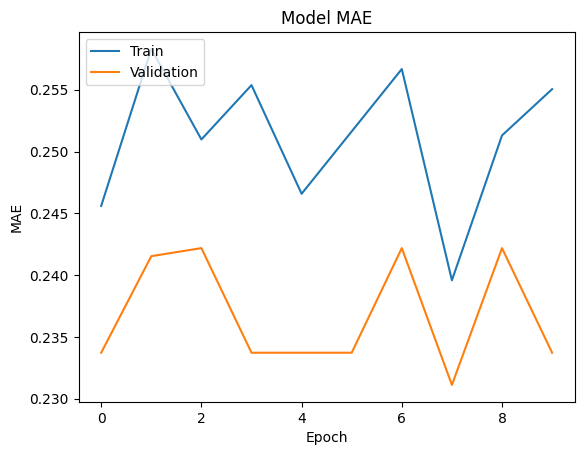

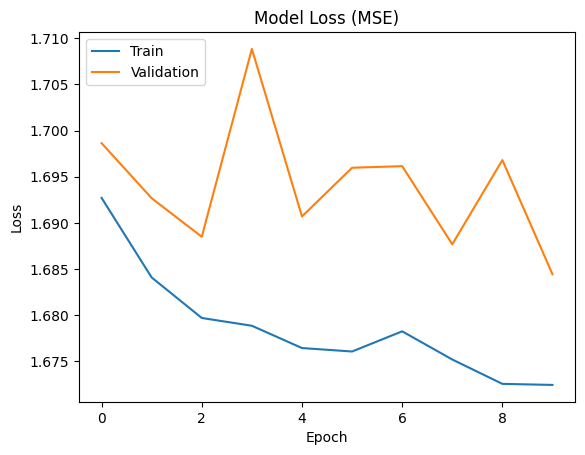

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation MAE values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values (MSE)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [12]:
folder_path = '../COMP90086_2024_Project_test/test'
test = np.genfromtxt('../COMP90086_2024_Project_test/test.csv', delimiter=',', skip_header=1)
ids = np.array(test, dtype=int)
print(ids)
test_image_data = load_images_from_folder(folder_path, ids)

[    95    706   2854 ... 998916 999235 999651]
95.jpg
706.jpg
2854.jpg
3093.jpg
4283.jpg
5449.jpg
5625.jpg
7860.jpg
8051.jpg
8812.jpg
10265.jpg
11329.jpg
11485.jpg
13901.jpg
15142.jpg
15176.jpg
15598.jpg
16132.jpg
16584.jpg
16840.jpg
16864.jpg
17375.jpg
17774.jpg
19140.jpg
19671.jpg
19834.jpg
19985.jpg
21275.jpg
21380.jpg
21728.jpg
23345.jpg
23418.jpg
24335.jpg
24604.jpg
26374.jpg
26566.jpg
27296.jpg
27572.jpg
27686.jpg
28146.jpg
28412.jpg
29213.jpg
29410.jpg
29443.jpg
29720.jpg
30147.jpg
30154.jpg
30813.jpg
30895.jpg
32835.jpg
33287.jpg
34108.jpg
34114.jpg
34252.jpg
34299.jpg
34477.jpg
34504.jpg
35120.jpg
36273.jpg
36647.jpg
36733.jpg
36818.jpg
37705.jpg
38348.jpg
38456.jpg
38463.jpg
39034.jpg
39083.jpg
39689.jpg
39736.jpg
39787.jpg
40053.jpg
40534.jpg
42846.jpg
43823.jpg
44092.jpg
44561.jpg
46366.jpg
47517.jpg
47714.jpg
48210.jpg
48662.jpg
48911.jpg
49738.jpg
50682.jpg
51047.jpg
51350.jpg
51358.jpg
51742.jpg
52173.jpg
52566.jpg
53571.jpg
53690.jpg
53776.jpg
54106.jpg
54175.jpg
54301

In [13]:


# Predict stable height on the test set
predicted_heights = model.predict(test_image_data)
adjusted_predicted_heights = predicted_heights + 1

print("Predicted heights:", adjusted_predicted_heights)
#TODO for some reason the output are not classes, but floats. Still need to see what went wrong


60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step
Predicted heights: [[1.2538046 1.2355282 1.198579  1.1521654 1.105199  1.0547239]
 [1.265526  1.2451738 1.1995734 1.147111  1.0962727 1.046343 ]
 [1.2558067 1.2371815 1.1988404 1.1513578 1.1036549 1.0531588]
 ...
 [1.2511052 1.2332916 1.1982145 1.1532391 1.1072869 1.0568626]
 [1.2613286 1.2417397 1.1992381 1.1489505 1.09945   1.0492932]
 [1.266802  1.246217  1.1996285 1.1465269 1.0953169 1.0455087]]


In [14]:
print(predicted_heights.shape)

(1920, 6)


In [19]:
for i in predicted_heights:
    for j in i:
        if j >= 2 or j < 1: print(j)

0.25380456
0.23552829
0.19857898
0.1521654
0.10519893
0.054723836
0.265526
0.24517381
0.19957343
0.1471111
0.09627275
0.046342924
0.25580668
0.23718154
0.19884036
0.15135777
0.103654884
0.053158768
0.22835967
0.2140946
0.1942762
0.16147001
0.12519003
0.07660943
0.25261083
0.2345387
0.19843936
0.15265222
0.106119886
0.05563895
0.2696335
0.24851838
0.19983076
0.14525026
0.09318181
0.043585245
0.25725612
0.23838964
0.19884968
0.15068385
0.10255683
0.05226381
0.26501313
0.24475515
0.1995369
0.14733909
0.09665946
0.04669627
0.27598438
0.25366202
0.19996506
0.14223288
0.08849414
0.039661504
0.23194322
0.2171632
0.19503477
0.16028681
0.12233366
0.07323832
0.2642915
0.2441631
0.19951251
0.1476712
0.09720042
0.047161244
0.25466728
0.236242
0.19868323
0.15181406
0.104533955
0.054059546
0.2616597
0.24200857
0.19929935
0.14882201
0.09919455
0.04901579
0.2524904
0.23443404
0.19848654
0.15273169
0.106208235
0.05564908
0.24670917
0.22961864
0.19776395
0.15504149
0.11069521
0.06017156
0.25704196
0.238